# Aprendizaje profundo y arte: transferencia de estilo neuronal

En esta tarea, aprenderá sobre la transferencia de estilo neuronal. Este algoritmo fue creado por [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

- Implementara el algoritmo de transferencia de estilo neuronal
- Genere imágenes artísticas novedosas usando su algoritmo

La mayoría de los algoritmos que ha estudiado optimizan una función de costo para obtener un conjunto de valores de parámetros. ¡En Neural Style Transfer, optimizará una función de costo para obtener valores de píxeles!

In [2]:
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

## 1 - Declaración del problema

La transferencia de estilo neuronal (NST) es una de las técnicas más divertidas en el aprendizaje profundo. Como se ve a continuación, fusiona dos imágenes, a saber: una imagen de "contenido" **(C) y una imagen de "estilo" (S), para crear una imagen "generada" (G**).

La imagen generada G combina el "contenido" de la imagen C con el "estilo" de la imagen S.

En este ejemplo, va a generar una imagen del museo del Louvre en París (imagen de contenido C), mezclada con una pintura de Claude Monet, líder del movimiento impresionista (imagen de estilo S).
<br><br>
<img src="images/louvre_generated.png" style="width:750px;height:200px;">

Veamos cómo puedes hacer esto.

## 2 - Transferencia de aprendizaje

La transferencia de estilo neuronal (NST) utiliza una red convolucional previamente entrenada y se basa en ella. La idea de usar una red entrenada en una tarea diferente y aplicarla a una nueva tarea se llama transferencia de aprendizaje.

Siguiendo el [documento original de NST](https://arxiv.org/abs/1508.06576), utilizaremos la red VGG. Específicamente, usaremos VGG-19, una versión de 19 capas de la red VGG. Este modelo ya ha sido entrenado en la gran base de datos de ImageNet y, por lo tanto, ha aprendido a reconocer una variedad de características de bajo nivel (en las capas menos profundas) y características de alto nivel (en las capas más profundas).

Ejecute el siguiente código para cargar parámetros del modelo VGG. Esto puede tardar unos pocos segundos.

In [3]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size,img_size,3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
vgg.trainable = False
pp.pprint(vgg)

## 3 - Transferencia de estilo neuronal (NST)

A continuación, construirá el algoritmo de transferencia de estilo neuronal (NST) en tres pasos:

- Primero, construirá la función de costo de contenido $J_{content}(C,G)$
- Segundo, construirá la función de costo de estilo $J_{estilo}(S,G)$
- Finalmente, juntarás todo para obtener $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. ¡Excitante!

### 3.1 - Cálculo del costo del contenido

#### 3.1.1 - Hacer que la imagen generada G coincida con el contenido de la imagen C

Un objetivo al que debe apuntar al realizar NST es que el contenido de la imagen G generada coincida con el contenido de la imagen C. Para hacerlo, necesitará comprender las <b> capas superficiales frente a las profundas </b>:

* Las capas menos profundas de una ConvNet tienden a detectar características de nivel inferior como <i>bordes y texturas simples</i>.
* Las capas más profundas tienden a detectar características de nivel superior, como <i> texturas y clases de objetos más complejas</i>.

#### Para elegir una capa de activación "media" $a^{[l]}$ :
Necesita que la imagen G "generada" tenga un contenido similar al de la imagen de entrada C. Suponga que ha elegido algunas activaciones de capa para representar el contenido de una imagen.
* En la práctica, obtendrá los resultados más agradables a la vista si elige una capa en el <b>medio</b> de la red, ni demasiado superficial ni demasiado profunda. Esto garantiza que la red detecte características de nivel superior e inferior.
* Una vez que haya terminado este ejercicio, siéntase libre de volver y experimentar usando diferentes capas para ver cómo varían los resultados.

#### Para propagar hacia adelante la imagen "C:"
* Establezca la imagen C como la entrada a la red VGG preentrenada y ejecute la propagación hacia adelante.
* Sean $a^{(C)}$ las activaciones de la capa oculta en la capa que haya elegido. (En la clase, esto se escribió como $a^{[l](C)}$, pero aquí se quitó el superíndice $[l]$ para simplificar la notación). Esto será $n_H \times n_W \times n_C $ tensor.

#### Para propagar hacia adelante la imagen  "G":
* Repita este proceso con la imagen G: establezca G como entrada y ejecute la progresión hacia adelante.
* Sea $a^{(G)}$ la activación de la capa oculta correspondiente.

En este ejemplo, la imagen de contenido C será la imagen del Museo del Louvre en París. Ejecute el siguiente código para ver una imagen del Louvre.



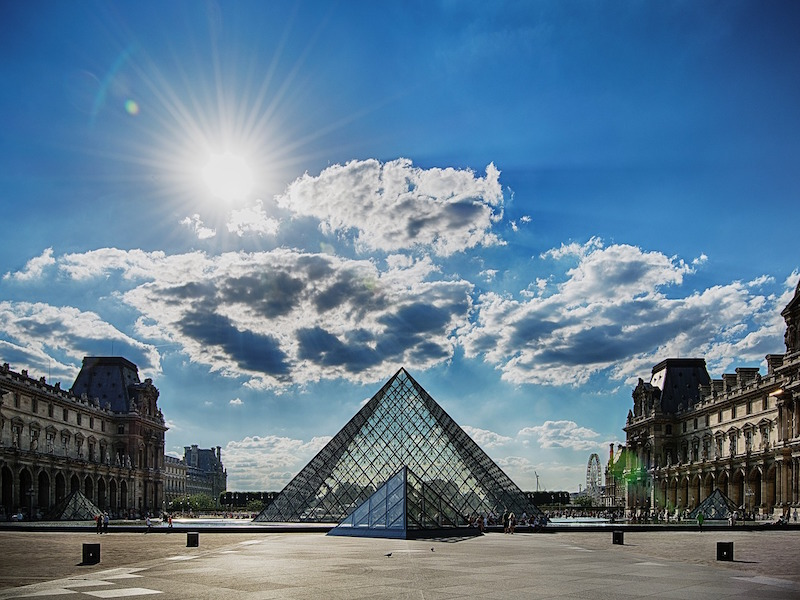

In [5]:
content_image = Image.open("images/louvre.jpg")
content_image

#### 4.1.2 - Función de costo de contenido $J_{contenido}(C,G)$
Un objetivo al que debe apuntar al realizar NST es que el contenido de la imagen G generada coincida con el contenido de la imagen C. Un método para lograrlo es calcular la función de costo del contenido, que se definirá como:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Aquí, $n_H, n_W$ y $n_C$ son la altura, el ancho y el número de canales de la capa oculta que ha elegido, y aparecen en un término de normalización en el costo.
* Para mayor claridad, tenga en cuenta que $a^{(C)}$ y $a^{(G)}$ son los volúmenes 3D correspondientes a las activaciones de una capa oculta.
* Para calcular el costo $J_{contenido}(C,G)$, también podría ser conveniente desenrollar estos volúmenes 3D en una matriz 2D, como se muestra a continuación.
* Técnicamente, este paso de desenrollado no es necesario para calcular $J_{contenido}$, pero será una buena práctica para cuando necesite realizar una operación similar más tarde para calcular el costo del estilo $J_{estilo}$.

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">

### compute_content_cost

Calcule el "costo del contenido" con TensorFlow.

**Instrucciones**:

`a_G`: activaciones de capas ocultas que representan el contenido de la imagen G
<br>
`a_C`: activaciones de capa oculta que representan el contenido de la imagen C

Los 3 pasos para implementar esta función son:
1. Recuperar dimensiones de `a_G`:
     - Para recuperar dimensiones de un tensor `X`, use: `X.shape`
2. Desenrolle `a_C` y `a_G` como se explica en la imagen de arriba
     - Es probable que desee utilizar estas funciones: [tf.transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) y [tf.reshape](https://www.tensorflow. org/api_docs/python/tf/reshape).
3. Calcule el costo del contenido:
     - Es probable que desee utilizar estas funciones: [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow. org/api_docs/python/tf/square) y [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract).
    
    
#### Sugerencias adicionales para "Desenrollar"
* Para desenrollar el tensor, desea que la forma cambie de $(m,n_H,n_W,n_C)$ a $(m, n_H \times n_W, n_C)$.
* `tf.reshape(tensor, shape)` toma una lista de enteros que representan la forma de salida deseada.
* Para el parámetro `shape`, un `-1` le dice a la función que elija el tamaño de dimensión correcto para que el tensor de salida aún contenga todos los valores del tensor original.
* Entonces `tf.reshape(a_C, shape=[m, n_H * n_W, n_C])` da el mismo resultado que `tf.reshape(a_C, shape=[m, -1, n_C])`.
* Si prefiere reordenar las dimensiones, puede usar `tf.transpose(tensor, perm)`, donde `perm` es una lista de enteros que contiene el índice original de las dimensiones.
* Por ejemplo, `tf.transpose(a_C, perm=[0,3,1,2])` cambia las dimensiones de $(m, n_H, n_W, n_C)$ a $(m, n_C, n_H, n_W)$ 
<!-- * Hay más de una manera de desenrollar un tensor. -->
* Nuevamente, tenga en cuenta que no necesariamente necesita `tf.transpose` para 'desenrollar' los tensores en este caso, pero esta es una función útil para practicar y comprender otras situaciones que encontrará.

In [11]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """

    a_C = content_output[-1]
    a_G = generated_output[-1]

    m, n_H, n_W, n_C = a_G.shape

    # Reshape a_C y a_G
    a_C_unrolled = tf.reshape(a_C, shape = [m,n_H*n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape = [m, n_H * n_W, n_C])

    # Calculamos el costo
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)

    return J_content

<font color = 'blue'>

- El costo del contenido toma una activación de capa oculta de la red neuronal y mide qué tan diferentes son $a^{(C)}$ y $a^{(G)}$.

- Cuando minimice el costo del contenido más adelante, esto ayudará a asegurarse de que $G$ tenga un contenido similar al de $C$.

### 4.2 - Cálculo del costo del estilo

Para el ejemplo en ejecución, utilizará la siguiente imagen de estilo:

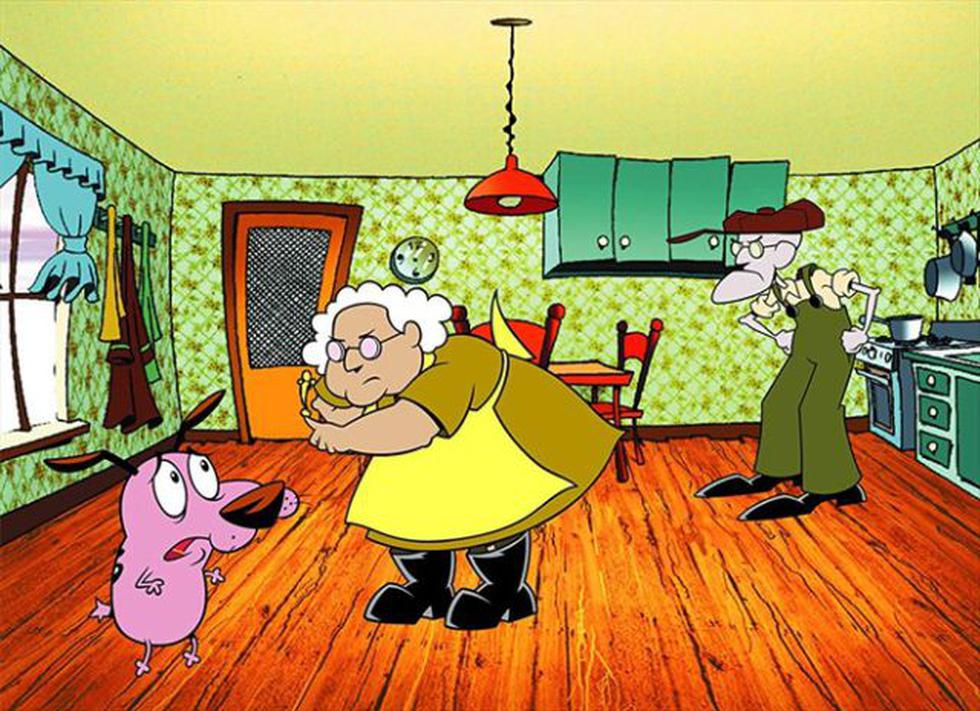

In [18]:
example = Image.open("images/courage.jpg")
example

#### 4.2.1 - Matriz de estilo

#### Gram matrix
* La matriz de estilo también se denomina "matriz de Gram".
* En álgebra lineal, la matriz de Gram G de un conjunto de vectores $(v_{1},\dots,v_{n})$ es la matriz de productos punto, cuyas entradas son ${\displaystyle G_{ij} = v_ {i}^T v_{j} = np.dot(v_{i}, v_{j}) }$.
* En otras palabras, $G_{ij}$ compara qué tan similar es $v_i$ a $v_j$: si son muy similares, esperaría que tuvieran un producto escalar grande y, por lo tanto, para $G_{ij}$ ser grande

#### Dos significados de la variable $G$
* Tenga en cuenta que hay una colisión desafortunada en los nombres de las variables que se usan aquí. Siguiendo la terminología común utilizada en la literatura:
     * $G$ se usa para denotar la matriz de estilo (o matriz Gram)
     * $G$ también denota la imagen generada.
* En aras de la claridad, en esta tarea se usará $G_{gram}$ para hacer referencia a la matriz de Gram y $G$ para indicar la imagen generada.

#### Calcular matriz de gram $G_{gram}$
Calculará la matriz de estilo multiplicando la matriz de filtro "desenrollada" por su transposición:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)ij}$: correlación
El resultado es una matriz de dimensión $(n_C,n_C)$ donde $n_C$ es el número de filtros (canales). El valor $G_{(gram)i,j}$ mide qué tan similares son las activaciones del filtro $i$ a las activaciones del filtro $j$.

#### $G_{(gram),ii}$: prevalencia de patrones o texturas
* Los elementos diagonales $G_{(gram)ii}$ miden qué tan "activo" es un filtro $i$.
* Por ejemplo, suponga que el filtro $i$ detecta texturas verticales en la imagen. Entonces $G_{(gram)ii}$ mide qué tan comunes son las texturas verticales en la imagen como un todo.
* Si $G_{(gram)ii}$ es grande, significa que la imagen tiene mucha textura vertical.


Al capturar la prevalencia de diferentes tipos de características ($G_{(gram)ii}$), así como la cantidad de características diferentes que ocurren juntas ($G_{(gram)ij}$), la matriz de estilo $G_{gram} $ mide el estilo de una imagen.

### Gram matrix
* Usando TensorFlow, implemente una función que calcule la matriz de Gram de una matriz A.
     * La fórmula es: La matriz de gram de A es $G_A = AA^T$.
* Es posible que desee utilizar estas funciones: [matmul](https://www.tensorflow.org/api_docs/python/tf/matmul) y [transpose](https://www.tensorflow.org/api_docs/python/tf/transponer).

In [21]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  

    GA = tf.matmul(A, tf.transpose(A))
    return GA

#### 4.2.2 - Style Cost

Su próximo objetivo será minimizar la distancia entre la matriz de Gram de la imagen de "estilo" S y la matriz de Gram de la imagen "generada" G.
* Por ahora, usará solo una sola capa oculta $a^{[l]}$.
* El costo de estilo correspondiente para esta capa se define como:

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Matriz de Gram de la imagen de "estilo".
* $G_{gram}^{(G)}$ Matriz de Gram de la imagen "generada".
* Asegúrese de recordar que este costo se calcula utilizando las activaciones de capa oculta para una capa oculta en particular en la red $a^{[l]}$

### compute_layer_style_cost

Calcule el costo del estilo para una sola capa.

**Instrucciones**: Los 3 pasos para implementar esta función son:
1. Recuperar dimensiones de las activaciones de la capa oculta a_G:
     - Para recuperar dimensiones de un tensor X, use: `X.shape`
2. Desenrolle las activaciones de la capa oculta a_S y a_G en matrices 2D, como se explica en la imagen de arriba (vea las imágenes en las secciones "cálculo del costo del contenido" y "matriz de estilo").
     - Puede usar [tf.transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) y [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reformar).
3. Calcule la matriz de estilo de las imágenes S y G. (Use la función que había escrito anteriormente).
4. Calcule el costo del estilo:
     - Puede encontrar [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow.org/api_docs/python/tf/square) y [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract) útiles.
    
    
#### Consejos adicionales
* Dado que las dimensiones de activación son $(m, n_H, n_W, n_C)$ mientras que la forma de matriz desenrollada deseada es $(n_C, n_H*n_W)$, se cambia el orden de la dimensión del filtro $n_C$. Entonces `tf.transpose` se puede usar para cambiar el orden de la dimensión del filtro.

In [24]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    m, n_H, n_W, n_C = a_G.shape

    # Remodelar las imágenes para tenerlos de forma (n_C, n_H*n_W)
    a_S = tf.transpose(tf.reshape(a_S, shape = [-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape = [-1, n_C]))

    # Calculando las gram_matrices para ambas imagenes S y G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Cálculo de la pérdida
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0*(n_H*n_W*n_C)**2)

    return J_style_layer

#### 4.2.3 Style Weights

* Hasta ahora has capturado el estilo de una sola capa.
* Obtendrá mejores resultados si "combina" los costos de estilo de varias capas diferentes.
* A cada capa se le asignarán pesos ($\lambda^{[l]}$) que reflejan cuánto contribuirá cada capa al estilo.
* Después de completar este ejercicio, no dude en volver y experimentar con diferentes pesos para ver cómo cambia la imagen generada $G$.
* Por defecto, dé a cada capa el mismo peso y los pesos suman 1. ($\sum_{l}^L\lambda^{[l]} = 1$)

In [26]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

In [27]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Eche un vistazo a la salida de una capa `block5_conv4`. Posteriormente definirá esto como la capa de contenido, que representará la imagen.

In [29]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

Ahora elija capas para representar el estilo de la imagen y asigne costos de estilo:

In [30]:
STYLE_LAYERS = [
    ('block1_conv1', 1.0),
    ('block2_conv1', 0.8),
    ('block3_conv1', 0.7),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.1)]

Puede combinar los costos de estilo para diferentes capas de la siguiente manera:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

donde los valores para $\lambda^{[l]}$ se dan en `STYLE_LAYERS`.

### compute_style_cost

<b> Instrucciones: </b>
* Ya se ha implementado una función compute_style_cost(...).
* Llama a su `compute_layer_style_cost(...)` varias veces y pondera sus resultados usando los valores en `STYLE_LAYERS`.

#### Descripción de `compute_style_cost`
Para cada capa:
* Seleccione la activación (el tensor de salida) de la capa actual.
* Obtenga el estilo de la imagen de estilo "S" de la capa actual.
* Obtener el estilo de la imagen generada "G" de la capa actual.
* Calcule el "costo de estilo" para la capa actual
* Agregue el costo de estilo ponderado al costo de estilo general (J_style)

Una vez que haya terminado con el ciclo:
* Devuelve el costo total del estilo.

In [31]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    '''
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    '''

    J_style = 0

    # Establecer a_S para que sea la activación de la capa oculta de la capa que hemos seleccionado.
    # El primer elemento de la matriz contiene la imagen de la capa de entrada, que no debe utilizarse.
    a_S = style_image_output[1:]

    # Establecer a_G para que sea la salida de las capas ocultas elegidas. 
    # El primer elemento de la lista contiene la imagen de la capa de entrada que no debe usarse.
    a_G = generated_image_output[1:]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Calcular style_cost para la capa actual
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Agregue el wegith * J_style_layer de esta capa al costo general del estilo
        J_style += weight[1] * J_style_layer

    return J_style


¿Cómo se eligen los coeficientes para cada capa? Las capas más profundas capturan conceptos de nivel superior, y las características de las capas más profundas están menos localizadas en la imagen entre sí. Entonces, si desea que la imagen generada siga suavemente la imagen del estilo, intente elegir pesos más grandes para las capas más profundas y pesos más pequeños para las primeras capas. Por el contrario, si desea que la imagen generada siga fielmente la imagen de estilo, intente elegir pesos más pequeños para las capas más profundas y pesos más grandes para las primeras capas.

<font color = 'blue'>

**Lo que debes recordar:**
    
- El estilo de una imagen se puede representar utilizando la matriz Gram de activaciones de una capa oculta.
- Obtiene resultados aún mejores al combinar esta representación de múltiples capas diferentes.
- Esto contrasta con la representación de contenido, donde normalmente es suficiente usar una sola capa oculta.
- Minimizar el costo del estilo hará que la imagen $G$ siga el estilo de la imagen $S$.

### 4.3 - Definición del costo total para optimizar

Finalmente, creará una función de costo que minimice tanto el estilo como el costo del contenido. La fórmula es:

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

### coste_total

Implemente la función de costo total que incluye tanto el costo del contenido como el costo del estilo.

In [32]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

<font color = 'blue'>

**Lo que debes recordar:**
- El costo total es una combinación lineal del costo del contenido $J_{content}(C,G)$ y el costo del estilo $J_{style}(S,G)$.
- $\alpha$ y $\beta$ son hiperparámetros que controlan la ponderación relativa entre contenido y estilo.

## 5 - Resolviendo el Problema de Optimización

¡Finalmente, puedes poner todo junto para implementar la transferencia de estilo neuronal!


Esto es lo que su programa puede hacer:

1. Cargue la imagen del contenido
2. Cargue la imagen de estilo
3. Inicializar aleatoriamente la imagen que se generará
4. Cargue el modelo VGG19
5. Calcule el costo del contenido
6. Calcule el costo del estilo
7. Calcule el costo total
8. Definir el optimizador y la tasa de aprendizaje

Aquí están los pasos individuales en detalle.

### 5.1 Cargar la imagen del contenido
Ejecute la siguiente celda de código para cargar, remodelar y normalizar su imagen de "contenido" C (la imagen del museo del Louvre):

(1, 400, 400, 3)


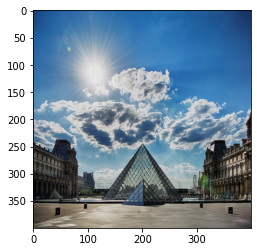

In [38]:
content_image = np.array(Image.open("images/louvre.jpg").resize((img_size, img_size)))
content_image = tf.constant(content_image.reshape((1,) + content_image.shape))

print(content_image.shape)
imshow(content_image[0])
plt.show()

### 5.2 Cargar la imagen de estilo
Ahora cargue, remodele y normalice su imagen de "estilo" (Un estilo de dibujo del dibujo animado `Coraje el perro cobarde`):



(1, 400, 400, 3)


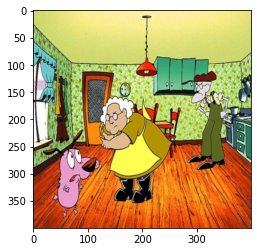

In [39]:
style_image =  np.array(Image.open("images/courage.jpg").resize((img_size, img_size)))
style_image = tf.constant(style_image.reshape((1,) + style_image.shape))

print(style_image.shape)
imshow(style_image[0])
plt.show()

### 5.3 Inicializar aleatoriamente la imagen que se va a generar
Ahora, puede inicializar la imagen "generada" como una imagen ruidosa creada a partir de content_image.

* La imagen generada está ligeramente correlacionada con la imagen del contenido.
* Al inicializar los píxeles de la imagen generada para que sean principalmente ruidosas pero ligeramente correlacionados con la imagen de contenido, esto ayudará a que el contenido de la imagen "generada" coincida más rápidamente con el contenido de la imagen de "contenido".

(1, 400, 400, 3)


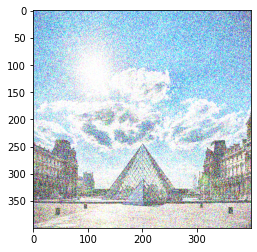

In [44]:
# tf.image.convert_image_dtype: Se escala por MAX (es el mayor número positivo representable para el tipo de datos)
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(generated_image.shape, 0, 0.8)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min = 0.0, clip_value_max = 1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()




## 5.4 - Cargar modelo VGG19 preentrenado
A continuación, defina una función que cargue el modelo VGG19 y devuelva una lista de las salidas para las capas intermedias.

In [48]:
def get_layer_outputs(vgg, layer_names):
    """ Crea un modelo vgg que devuelve una lista de valores de salida intermedios."""

    # layer_names tiene elementos de 'capa'.
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Ahora, defina la capa de contenido y construya el modelo.

In [49]:
content_layer = [('block5_conv4', 1)]
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Guarde las salidas para las capas de contenido y estilo en variables separadas.

In [50]:
content_target = vgg_model_outputs(content_image) # Content encoder
style_targets = vgg_model_outputs(style_image) # Style enconder

### 5.5 - Calcular el costo total

#### 5.5.1 - Calcular el costo del contenido

Ha construido el modelo, y ahora para calcular el costo del contenido, ahora asignará `a_C` y `a_G` para que sean las activaciones de capa oculta apropiadas. Utilizará la capa `block5_conv4` para calcular el costo del contenido. El siguiente código hace lo siguiente:

1. Configure a_C para que sea el tensor que activa la capa oculta para la capa "block5_conv4".
2. Establezca a_G para que sea el tensor que activa la capa oculta para la misma capa.
3. Calcule el costo del contenido usando a_C y a_G.

#### Solo recuerda
`vgg_model_outputs(preprocessed_input)` genera un modelo devuelto por `get_layer_outputs(vgg, layer_names)` cuando la entrada de la matriz `layer_names` es STYLE_LAYERS + content_layer.
content_layer es ('block5_conv4', 1) como decidimos nosotros al principio

#### Importante
Las imágenes codificadas precalculadas (a_S y a_C) calculadas en este paso se usarán en el entrenamiento para calcular el costo w.r.t a_G (las salidas vgg_model_) para la imagen generada actual en cada paso de entrenamiento.

A continuación se encuentran las herramientas que necesitará para mostrar las imágenes generadas por el modelo de transferencia de estilo.